In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import seaborn as sb

%matplotlib inline

## Pre-Task: Describe the goals of your study

Given a partial set of the Titanic passenger list, use the information in this partial set to create a prediction model with which to predict the survivability of the remaining passengers.

## Part 1: Aquire the Data

#### 1. Connect to the remote database

In [2]:
# use psql to pull data from remote db
# psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
# password: gastudents
# \copy train to 'aws_train.csv' csv header

In [3]:
# now bail on psql and just use pandas
df = pd.read_csv('aws_train.csv')

In [4]:
for i in ['index','Name','Ticket','Cabin','PassengerId']:
    del df[i]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [6]:
df[df['Embarked'].isnull() == True]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,NaN
829,1,1,female,62.0,0,0,80.0,NaN


In [7]:
df.pivot_table('Fare', index=['Sex', 'Pclass'], columns = ['Embarked'], aggfunc=len)
# df.groupby(['Sex','Pclass','Embarked'])['Pclass'].count()

Embarked          C     Q      S
Sex    Pclass                   
female 1       43.0   1.0   48.0
       2        7.0   2.0   67.0
       3       23.0  33.0   88.0
male   1       42.0   1.0   79.0
       2       10.0   1.0   97.0
       3       43.0  39.0  265.0

In [8]:
df['Embarked'] = df['Embarked'].fillna('S')

In [9]:
# convert variables to categories
for i in ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']:
    df[i] = df[i].astype('category')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null category
Pclass      891 non-null category
Sex         891 non-null category
Age         714 non-null float64
SibSp       891 non-null category
Parch       891 non-null category
Fare        891 non-null float64
Embarked    891 non-null category
dtypes: category(6), float64(2)
memory usage: 19.4 KB


In [11]:
df.groupby(['Pclass'])['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [12]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return 38.2
        elif Pclass == 2:
            return 29.8
        else:
            return 25.1
    else:
        return Age

In [13]:
df['Age']= df[['Age','Pclass']].apply(impute_age,axis=1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null category
Pclass      891 non-null category
Sex         891 non-null category
Age         891 non-null float64
SibSp       891 non-null category
Parch       891 non-null category
Fare        891 non-null float64
Embarked    891 non-null category
dtypes: category(6), float64(2)
memory usage: 19.4 KB


#### 2. Query the database and aggregate the data

In [15]:
# left the database behind a long time ago

## Part 2: Exploratory Data Analysis

#### 1. Describe the Data

This data describes various information about a subset of the passengers of the Titanic:
- demographic data (e.g., age, sex, marital status)
- relationships with other passengers (e.g., sibling, spouse, parent, child)
- logistical (e.g., ticket number, port of embarcation, cabin)

However there is one data point that is most important for our purposes:
- survival (1=survived, 0=did not)

##### Category descriptions:  
(from Kaggle description at https://www.kaggle.com/c/titanic/data)

**Pclass** is a proxy for socio-economic status (SES)  
- 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

**Age** is in Years; Fractional if Age less than One (1)
- If the Age is Estimated, it is in the form xx.5

The following are the definitions used for sibsp and parch:
- **Sibling**:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
- **Spouse**:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
- **Parent**:   Mother or Father of Passenger Aboard Titanic
- **Child**:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.

##### Assumptions:
- Some of the data is missing and will require either discarding or imputation
    - Missing ages were imputed from the mean of each of the three passenger classes
    - Missing embarkation locations were imputed by the mode of the sex and class of the individual, i.e., where the majority of like passengers embarked. This turned out to be the same for all categories - Southampton.

#### 2. Visualize the Data

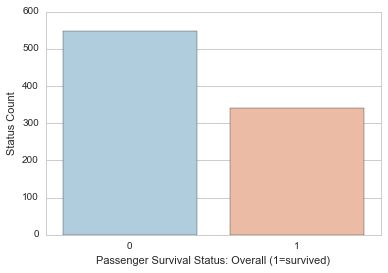

In [16]:
# show relationship of survived vs not totals
sb.set_style('whitegrid')
sb.countplot(x='Survived',data=df,palette='RdBu_r')
plt.xlabel("Passenger Survival Status: Overall (1=survived)")
plt.ylabel("Status Count")
plt.show()

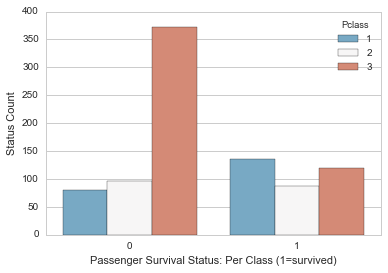

In [17]:
# show survival rate per passenger class
sb.countplot(x='Survived',hue='Pclass',data=df,palette='RdBu_r')
plt.xlabel("Passenger Survival Status: Per Class (1=survived)")
plt.ylabel("Status Count")
plt.show()


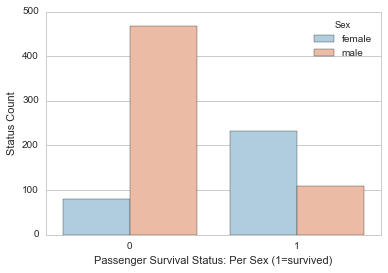

In [18]:
sb.countplot(x='Survived', hue='Sex', data=df,palette='RdBu_r')
plt.xlabel("Passenger Survival Status: Per Sex (1=survived)")
plt.ylabel("Status Count")
plt.show()

## Part 3: Data Wrangling

#### 1. Create Dummy Variables for *Sex*  use sklearn pipline

In [19]:
# don't know how to use sklearn pipeline to do so

In [20]:
# pd.get_dummies(df['Pclass'],drop_first=True)
df[['Pclass2','Pclass3']] = pd.get_dummies(df['Pclass'], drop_first=True)

In [21]:
del df['Pclass']

In [22]:
df['Sex'] = pd.get_dummies(df['Sex'], drop_first=True)

In [23]:
df.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked,Pclass2,Pclass3
0,0,1.0,22.0,1,0,7.2500,S,0.0,1.0
1,1,0.0,38.0,1,0,71.2833,C,0.0,0.0
2,1,0.0,26.0,0,0,7.9250,S,0.0,1.0
3,1,0.0,35.0,1,0,53.1000,S,0.0,0.0
4,0,1.0,35.0,0,0,8.0500,S,0.0,1.0


## Part 4: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

In [24]:
y = df['Survived']
X = df[['Sex', 'Age','Pclass2','Pclass3']]

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

In [25]:
# not sure exactly what this means, but assume I did it above as Isaac 
# helped me with that part (creating my X,y variables)
# and we did it this way because we coudn't figure out patsy and he couldn't 
# answer why we eliminate the first column when we create dummy variables

#### 3. Conduct the logistic regression

In [26]:
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
import patsy
from sklearn.cross_validation import KFold
from statsmodels.discrete.discrete_model import Logit
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

logreg = LogisticRegression()
logreg.fit(X_train,y_train)


/Users/deepstructure/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 4. Examine the coefficients

In [27]:
print('classes: ',logreg.classes_)
print('coefficients: ',logreg.coef_)
print('intercept :', logreg.intercept_)

('classes: ', array([0, 1]))
('coefficients: ', array([[-2.38292518, -0.02428692, -0.778216  , -2.00378506]]))
('intercept :', array([ 2.89632836]))


#### 6. Test on a *Test* 

In [28]:
y_pred = logreg.predict(X_test)
y_pred

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0])

#### 7. Predict the class labels for the *Test* set

In [29]:
# not sure what this means - does it mean reverse-engineer the pclass from the survival rate?
# or does it mean just call my 1s survivors and my 0s deaths?

#### 8. Predict the class probabilities for the *Test* set

In [30]:
# have no idea if this is corect, but looked like the right code to crib
Y_pp = pd.DataFrame(logreg.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
print(Y_pp.iloc[0:10])

   class_0_pp  class_1_pp
0    0.602132    0.397868
1    0.917835    0.082165
2    0.867493    0.132507
3    0.906155    0.093845
4    0.337610    0.662390
5    0.602132    0.397868
6    0.316239    0.683761
7    0.122021    0.877979
8    0.823313    0.176687
9    0.890902    0.109098


#### 10. Cross validate on 10 folds

In [39]:
# logreg = LogisticRegression()
# logreg.fit(X_train,y_train)
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

print('INITIAL MODEL ACCURACY (NO Cross Validation: ', logreg.score(X_train, y_train))

('INITIAL MODEL ACCURACY (NO Cross Validation: ', 0.797752808988764)


In [83]:
# I took both the code in the box above and here from the Wisconsin workbook
# (DSI_DTLA_2/curriculum/week-04/4.2-Model-Comparison-and-Tuning/Wisconsin-Breast-Cancer-KNN.ipynb),
# but for some reason this line of it isn't working with my test_train_split values. 
# However the code does work with my originally defined X, y

# CV
scores = cross_validation.cross_val_score(logreg, X_train, y_train, scoring='accuracy', cv=10)
print('CV 10-FOLD Scores: ', scores)
print('CV 10-FOLD Mean Accuracy', scores.mean() )
print('CV 10-FOLD Standard Deviation of Accuracy', scores.std() )

TypeError: take_nd() got an unexpected keyword argument 'axis'

In [81]:
X.head(2)

,Sex,Age,Pclass2,Pclass3
0,1.0,22.0,0.0,1.0
1,0.0,38.0,0.0,0.0


In [82]:
X_train.head(2)

,Sex,Age,Pclass2,Pclass3
467,1.0,56.0,0.0,0.0
714,1.0,52.0,1.0,0.0


In [84]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
Sex        891 non-null float64
Age        891 non-null float64
Pclass2    891 non-null float64
Pclass3    891 non-null float64
dtypes: float64(4)
memory usage: 27.9 KB


In [85]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 467 to 528
Data columns (total 4 columns):
Sex        712 non-null float64
Age        712 non-null float64
Pclass2    712 non-null float64
Pclass3    712 non-null float64
dtypes: float64(4)
memory usage: 27.8 KB


In [86]:
# does cross_validation.cross_val_score need the array to be indexed 0-n?

#### 11. Check the Classification Report

In [44]:
# at this point I am truly just searching for code on our github, cutting and pasting, and changing the variables
# to match the ones I used

from sklearn.metrics import classification_report

def print_cm_cr(y_test, y_pred):
    """prints the confusion matrix and the classification report"""
    confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    print confusion
    print
    print classification_report(y_test, y_pred)
    
print_cm_cr(y_test, y_pred)

Predicted    0   1  All
Actual                 
0           98  16  114
1           20  45   65
All        118  61  179

             precision    recall  f1-score   support

          0       0.83      0.86      0.84       114
          1       0.74      0.69      0.71        65

avg / total       0.80      0.80      0.80       179



#### 12. What do the classification metrics tell us?

In [54]:
# Don't know - the only term that looks like anything is the term "precision". 
# I remember "recall" being an alias for something (specificity?), but don't
# really understand what it is

# Although if I had time, I could figure it out from this:
# https://en.wikipedia.org/wiki/Precision_and_recall

#### 13. Check the Confusion Matrix

#### 14. What does the Confusion Matrix tell us? 

In [55]:
# That for 16 people we predicted them to live when they died
# and for 20 people we predicted they'd perished and they survived.

#### 15. Plot the ROC curve

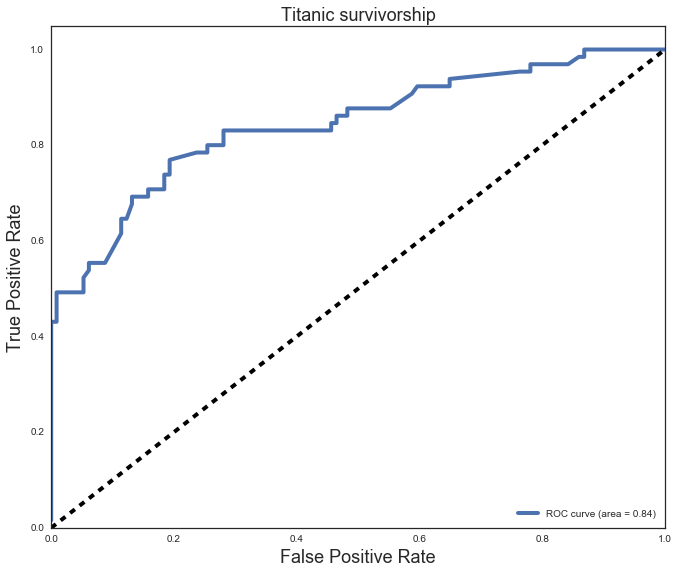

In [56]:
# don't really understand this at all
# just copied the code from the cancer workbook
# as evidenced by not knowing even whether or what to label the x and y axis

from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-white')

y_score = logreg.decision_function(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Titanic survivorship', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### 16. What does the ROC curve tell us?

In [57]:
# Apparently that the model is better than a 50/50 guess.

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

In [87]:
# have figured out that for some reason these functions don't like my train,test split arrays
# if I use X, y this function works
# if I use X_train, y_train, it breaks

from sklearn.grid_search import GridSearchCV

logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,10),
    'solver':['liblinear']
}

gs = GridSearchCV(estimator=logreg,param_grid=logreg_parameters, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X, y)
print('Grid Search Best Score: %.4f' % gs.best_score_)
print('Grid Search Best Parameter for C: ')
print gs.best_params_

Grid Search Best Score: 0.7969
Grid Search Best Parameter for C: 
{'penalty': 'l1', 'C': 0.46415888336127725, 'solver': 'liblinear'}


#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

In [88]:
# It's very slightly worse. Although this isn't my same set.

#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

In [ ]:
# Lasso will reduce variables to zero. Ridge will reduce but not eliminate, variables.

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

In [ ]:
# Lasso is useful for variable selection, Ridge is good for variable tuning.

#### 5. Explain how the regularization strength (C) modifies the regression loss function. Why do the Ridge and Lasso penalties have their respective effects on the coefficients?

In [52]:
# C controls the power of the loss function. Don't understand the second question.

#### 6.a. You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

In [72]:
# don't know how to do this

## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

In [75]:
# Since my X_train, y_train arrays don't work, for the sake of having something computed
# I'm using my original X, y

# gridsearch kNN
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    'n_neighbors':range(5,20),
    'weights':['distance','uniform']
}

knn_gs = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, verbose=1)
knn_gs.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'weights': ['distance', 'uniform']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

In [77]:
knn_best = knn_gs.best_estimator_
print knn_gs.best_params_
print knn_gs.best_score_

{'n_neighbors': 13, 'weights': 'distance'}
0.799102132435


#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### Why?

In [78]:
# Without seeing all the other results I wouldn't know what the different results were for the different 
# neighbor numbers - and I don't know how to show these
# 
# And I don't really understand bias-variance well enough to answer how changing the number would effect that

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

In [ ]:
# seems logistical regression would be better suited to a true yes/no results,
# whereas KNN makes more sense for classification

### -------------------------------- Didn't get any further than this --------------------------------

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

#### 7. Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

## Part 7: Precision-recall

#### 1. Gridsearch the same parameters for logistic regression but change the scoring function to 'average_precision'

`'average_precision'` will optimize parameters for area under the precision-recall curve instead of for accuracy.

#### 2. Examine the best parameters and score. Are they different than the logistic regression gridsearch in part 5?

#### 3. Create the confusion matrix. Is it different than when you optimized for the accuracy? If so, why would this be?

#### 4. Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

[See the sklearn plotting example here.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)